# 1. Setup

In [1]:
!pip install git+https://github.com/usgs/geomag-algorithms.git
!pip install git+https://github.com/samiriff/mars-ode-data-access.git

  Cloning https://github.com/usgs/geomag-algorithms.git to /tmp/pip-req-build-ux4bt_ev
  Running command git clone -q https://github.com/usgs/geomag-algorithms.git /tmp/pip-req-build-ux4bt_ev
     |████████████████████████████████| 23.9MB 3.5MB/s 
     |████████████████████████████████| 215kB 50.5MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-bf603w2q/wheels/dc/8b/cb/0141ac2aa76db65e2037c96bf61b63c26a64a1eb4ddb6f7eeb
  Stored in directory: /root/.cache/pip/wheels/11/d6/40/c448464ae42229b2f9fb46b71be0213e10e9628346b7f1198f
  Stored in directory: /root/.cache/pip/wheels/89/40/f5/7b4f2285aca871b5173887a6c69127210d92806c0d3a977e51
Successfully built geomag-algorithms obspy pycurl
  Cloning https://github.com/samiriff/mars-ode-data-access.git to /tmp/pip-req-build-0zt0nmck
  Running command git clone -q https://github.com/samiriff/mars-ode-data-access.git /tmp/pip-req-build-0zt0nmck
     |████████████████████████████████| 19.7MB 3.4MB/s 
     |████████████████████████████████| 20.1

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# 2. Imports

In [0]:
from ode_data_access.query_processor import QueryProcessor
from ode_data_access.query_result_processor import QueryResultProcessor
import numpy as np
from fastai.vision import *
from fastai.imports import *
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import PIL
from pathlib import Path
import cv2
from tqdm import tqdm_notebook as tqdm
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 3. Query Processing
- Run the following cells multiple times with different query parameters
- Each run will take care of aggregating chunks in the vectorized_chunks list
- Once you have got all the results you require, save the vectorized_chunks list as an NPZ file by going to step 4

In [4]:
# Query Parameters
target = 'mars'  # Aimed planetary body, i.e., Mars, Mercury, Moon, Phobos, or Venus
mission = 'MRO'  # Aimed mission, e.g., MGS or MRO
instrument = 'HIRISE'  # Aimed instrument from the mission, e.g., HIRISE or CRISM
product_type = 'RDRV11'  # Type of product to look for, e.g., DTM or RDRV11
western_lon = 234.24  # Western longitude to look for the data, from 0 to 360
eastern_lon = 234.25  # Eastern longitude to look for the data, from 0 to 360
min_lat = 68.21  # Minimal latitude to look for the data, from -90 to 90
max_lat = 68.22  # Maximal latitude to look for the data, from -90 to 90
product_id = '*160*RED*'  # PDS Product Id to look for, with wildcards (*) allowed
min_ob_time = ''  # Minimal observation time in (even partial) UTC format, e.g., '2017-03-01'
max_ob_time = ''  # Maximal observation time in (even partial) UTC format, e.g., '2017-03-01'
file_name = '*RED.(NOMAP.thumb.jpg|LBL)'  # File name to look for, with wildcards (*) allowed
#file_name = '*RED.(JP2|LBL)'  # File name to look for, with wildcards (*) allowed
product_types = set(['PRODUCT DATA FILE', 'BROWSE', 'GREYSCALE THUMBNAIL'])
number_product_limit = 10  # Maximal number of products to return (100 at most)
result_offset_number = 0  # Offset the return products, to go beyond the limit of 100 returned products
remove_ndv = True  # Replace the no-data value as mentionned in the label by np.nan
bin_type = 1 # Type of binning used in image - Bin1 = 0.35 cm/pixel, Bin2 = 2xBin1, Bin4 = 2xBin2

# Chunk Settings
is_chunking_required = False
SAVE_DIR_PREFIX = './chunks'
CHUNK_SIZE = 1024
SKIP_BLACK_IMAGES = True  # Set to False to retain all images that contain black pixels

# Default Settings to Align and Crop images with black margins
MAX_BORDER_SIZE = 200   # Border to be checked around the image
SAFETY_MARGIN = 0       # Removes extra pixels from the sides to make sure no black remains
TOLERANCE = 10          # A gray value is more likely to be considered black when you increase the tolerance
ALIGN_AND_CROP_THRESHOLDS = (MAX_BORDER_SIZE, SAFETY_MARGIN, TOLERANCE) # Set to None to prevent alignment and cropping

# Query Result Processing
query_processor = QueryProcessor()
query_results = query_processor.query_files_urls(target, mission, instrument, product_type,
                                                 western_lon, eastern_lon, min_lat, max_lat,
                                                 min_ob_time, max_ob_time, product_id, file_name,
                                                 number_product_limit, result_offset_number)
print("Total Number of Files of all bin types =", len(query_results.keys()))
query_result_processor = QueryResultProcessor()
should_continue = query_result_processor.download(query_results, bin_type, product_types)
if is_chunking_required and should_continue:
  query_result_processor.process(SAVE_DIR_PREFIX, CHUNK_SIZE, SKIP_BLACK_IMAGES, ALIGN_AND_CROP_THRESHOLDS, vectorized_chunks)
print("Task Completed")

Query URL: http://oderest.rsl.wustl.edu/live2/?target=mars&ihid=MRO&iid=HIRISE&pt=RDRV11&westernlon=234.24&easternlon=234.25&minlat=68.21&maxlat=68.22&query=product&results=fp&output=XML&limit=10&offset=0&productid=*160*RED*
File URLs: OrderedDict([('https://hirise.lpl.arizona.edu/PDS/RDR/ESP/ORB_016100_016199/ESP_016160_2485/ESP_016160_2485_RED.LBL', ('ESP_016160_2485_RED', 'PRODUCT LABEL FILE')), ('https://hirise.lpl.arizona.edu/PDS/EXTRAS/RDR/ESP/ORB_016100_016199/ESP_016160_2485/ESP_016160_2485_RED.NOMAP.thumb.jpg', ('ESP_016160_2485_RED', 'GREYSCALE THUMBNAIL'))])
Total Number of Files of all bin types = 2
Required Product Names matching the given bin type = {'ESP_016160_2485_RED'}
Total number of images to be downloaded = 1

Do you wish to proceed? [Y/n] y
...100%, 0 MB, 2337 KB/s, 0 seconds passed
----
Task Completed


# 4. Load Trained U-Net Model

In [5]:
from google.colab import drive
drive.mount('/content/google_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/google_drive


In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
learn = load_learner('google_drive/My Drive/Mars-Omdena', 'trained_unet_762394.pkl')

# 5. Prediction

In [0]:
classes = ['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider']
test_data = ImageDataBunch.single_from_classes('.', classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [0]:
!mkdir tmp

In [0]:
tmp_path = Path('tmp')

In [16]:
test_img_name = 'ESP_016160_2485_RED.NOMAP.thumb.jpg'
img = mpimg.imread(test_img_name)
rows, cols = map(lambda x : x // 224, img.shape)
img = PIL.Image.fromarray(img)
print('Rows =', rows, ', Cols =', cols)

Rows = 8 , Cols = 2


In [17]:
result_img = None
for row in tqdm(range(cols)):
  horizontal_result_img = None
  for col in (range(rows)):
    area = (224 * row, 224 * col, 224 * (row + 1), 224 * (col + 1))
    cropped_img = img.crop(area)
    resized_img = cropped_img.resize((224, 224))
    resized_img.save(tmp_path/'test.jpg')

    pred = learn.predict(open_image(tmp_path/'test.jpg'))

    background = np.array(resized_img)
    foreground = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
    blended_img = cv2.addWeighted(background, 1, foreground, 0.5, 0)
    
    if horizontal_result_img is None:
      horizontal_result_img = blended_img
    else:
      horizontal_result_img = np.concatenate((horizontal_result_img, blended_img), axis=0)
  if result_img is None:
    result_img = horizontal_result_img
  else:
    result_img = np.concatenate((result_img, horizontal_result_img), axis=1)

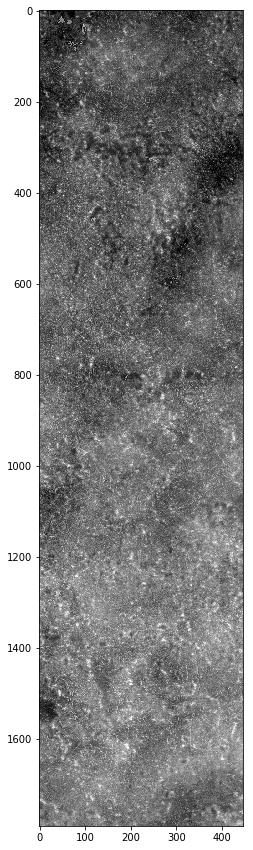

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(result_img, cmap='gray')

# Extras

## Converting Landing Site Coordinates to Planetocentric Coordinates that can be understood by ODE

In [0]:
import pandas as pd
import re

In [0]:
def convert_latitude(latitude):
  value, direction = latitude.split(' ')
  return value if direction == 'N' else -float(value)

In [0]:
def convert_longitude(longitude):
  value, direction = longitude.strip().split(' ')
  value = float(value)
  if direction == 'W':
    value = 360 - value
  return value

In [0]:
with open('../Landing_sites.csv', 'r') as f:
  lines = f.readlines()
  formatted_lines = []
  regex = re.compile(".*?\((.*?)\)")
  for line in lines:
    formatted_line = line.strip()
    formatted_line = re.sub("[\(\[].*?[\)\]]", "", formatted_line)
    formatted_lines.append(formatted_line.split(', '))
    
landing_sites = pd.DataFrame(formatted_lines, columns=['Mission', 'Latitude', 'Longitude', 'Status'])
landing_sites['Latitude'] = landing_sites['Latitude'].apply(convert_latitude)
landing_sites['Longitude'] = landing_sites['Longitude'].apply(convert_longitude)
landing_sites

,Mission,Latitude,Longitude,Status
0,Mars 2,-45,47.000000,Failed
1,Mars 3,-45,202.000000,Failed
2,Mars 6,-23.9,340.580000,Failed
3,Viking 1,22.48,310.030000,Successful
4,Mars Polar Lander,-76.57,165.200000,Failed
5,Pathfinder,19.33,326.450000,Successful
6,Beagle 2,10.6,90.000000,Failed
7,Spirit,-14.5719,175.478480,Successful
8,Opportunity,-1.9462,354.473400,Successful
9,Phoenix,68.218830,234.250778,Successful


In [0]:
landing_sites.to_csv('./landing_sites_ode_coordinates.csv')